🚀 Training...
 [7/7 4:30, Epoch 1/100]
Step	Training Loss
TrainOutput(global_step=7, training_loss=1.5562, metrics={'train_runtime': 270.91, 'train_samples_per_second': 1.772, 'train_steps_per_second': 0.222, 'total_flos': 13879517263145.0, 'train_loss': 1.5562, 'epoch': 1.0})
 [7/7 5:21, Epoch 2/100]
Step	Training Loss
TrainOutput(global_step=7, training_loss=0.7799, metrics={'train_runtime': 321.51, 'train_samples_per_second': 1.493, 'train_steps_per_second': 0.187, 'total_flos': 13879577232780.0, 'train_loss': 0.7799, 'epoch': 2.0})
 [7/7 5:46, Epoch 3/100]
Step	Training Loss
TrainOutput(global_step=7, training_loss=0.5805, metrics={'train_runtime': 346.7, 'train_samples_per_second': 1.384, 'train_steps_per_second': 0.173, 'total_flos': 13879521990971.0, 'train_loss': 0.5805, 'epoch': 3.0})
 [7/7 5:24, Epoch 4/100]
Step	Training Loss
TrainOutput(global_step=7, training_loss=0.4121, metrics={'train_runtime': 324.33, 'train_samples_per_second': 1.48, 'train_steps_per_second': 0.185, '

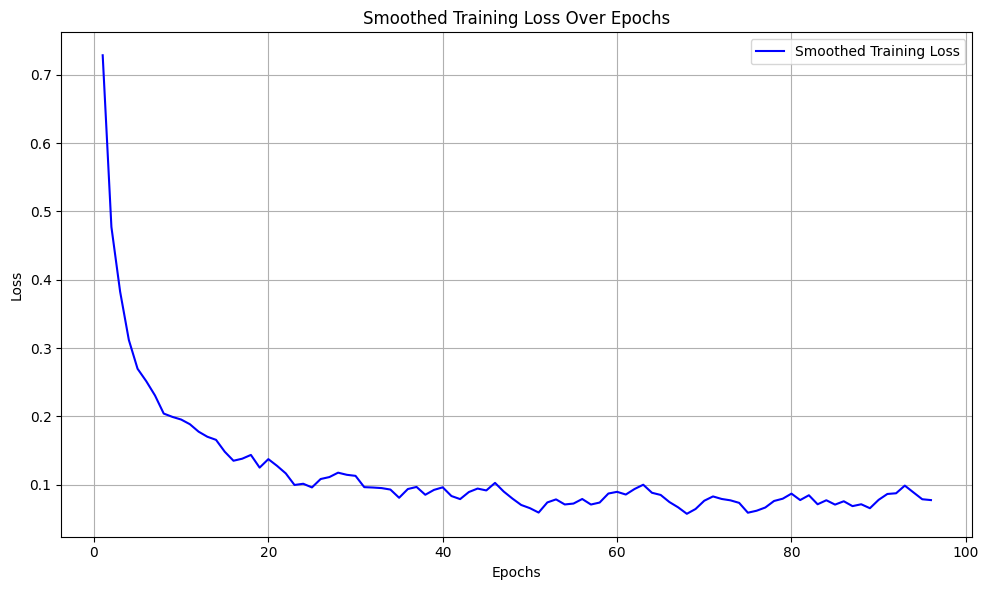

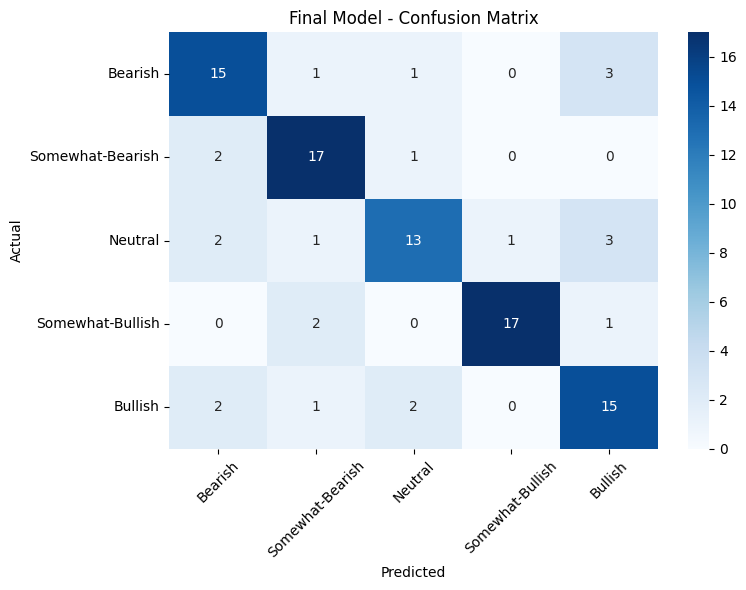

In [9]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Disable wandb
os.environ["WANDB_DISABLED"] = "true"

try:
    df = pd.read_csv("sentiments.csv")
except FileNotFoundError:
    print("No local file found, using sample data")
    data = {
        'summary': [
            "Company reports strong earnings growth",
            "Profit margins decline amid market pressures",
            "Stable performance in volatile market",
            "New product launch exceeds expectations",
            "Regulatory concerns weigh on shares"
        ],
        'overall_sentiment_label': [
            "Bullish", "Bearish", "Neutral", "Somewhat-Bullish", "Somewhat-Bearish"
        ]
    }
    df = pd.DataFrame(data)

df = df[['summary', 'overall_sentiment_label']].dropna()

# Reduce dataset size drastically for speed
df = df.sample(frac=0.8, random_state=42)  # Use 20% of data

# Label mapping
label2id = {
    "Bearish": 0,
    "Somewhat-Bearish": 1,
    "Neutral": 2,
    "Somewhat-Bullish": 3,
    "Bullish": 4
}

# Encode labels
df['label'] = df['overall_sentiment_label'].map(label2id).astype(int)

# Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['summary'], df['label'],
    test_size=0.2, stratify=df['label'], random_state=42
)

# Tokenizer & Model
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-pretrain")
model = BertForSequenceClassification.from_pretrained(
    "yiyanghkust/finbert-pretrain",
    num_labels=len(label2id)
)

# Tokenization
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)

# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = SentimentDataset(train_encodings, list(train_labels))
val_dataset = SentimentDataset(val_encodings, list(val_labels))

training_args = TrainingArguments(
    output_dir="./fast_model",
    num_train_epochs=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    save_strategy="no",
    load_best_model_at_end=False,
    logging_steps=50,  # Log every 50 steps
    logging_dir='./logs',  # Save logs to this directory
)


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset  # Will use this for evaluation and confusion matrix
)

# Train
print("🚀 Training...")
trainer.train()

# Evaluation to generate predictions for confusion matrix
predictions, labels, _ = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(labels, predicted_labels)

# Classification report
report = classification_report(labels, predicted_labels, target_names=list(label2id.keys()))
print("🔍 Final Model Results After 100 Epochs:")
print(report)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label2id.keys()),
            yticklabels=list(label2id.keys()))
plt.title("Final Model - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [5]:
def predict_sentiment_for_ticker(ticker, news_text):
    # Tokenize input text
    inputs = tokenizer(news_text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Calculate probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)[0]
    label_idx = torch.argmax(probs).item()

    # Get label mapping (works for both 3-class and 5-class versions)
    id2label = {v: k for k, v in label2id.items()}
    label = id2label[label_idx]

    # Prepare probability dictionary
    prob_dict = {id2label[i]: float(probs[i]) for i in sorted(id2label.keys())}

    # Print results
    print(f"\n📍 Ticker: {ticker}")
    print(f"📰 News Snippet: {news_text[:100]}...")
    print(f"🔮 Predicted Sentiment: {label}")
    print("📊 Probabilities:")
    for sentiment, prob in prob_dict.items():
        print(f"   {sentiment}: {prob:.2f}")

    return {
        "ticker": ticker,
        "label": label,
        "probs": prob_dict
    }

# 🔎 Example usage for 5-class version:
predict_sentiment_for_ticker(
    "ZM",
    "Zoom shares surged after the company posted better-than-expected quarterly results, though some analysts remain cautious about long-term growth prospects."
)



📍 Ticker: ZM
📰 News Snippet: Zoom shares surged after the company posted better-than-expected quarterly results, though some anal...
🔮 Predicted Sentiment: Somewhat-Bullish
📊 Probabilities:
   Bearish: 0.07
   Somewhat-Bearish: 0.09
   Neutral: 0.35
   Somewhat-Bullish: 0.40
   Bullish: 0.08


{'ticker': 'ZM',
 'label': 'Somewhat-Bullish',
 'probs': {'Bearish': 0.0707177072763443,
  'Somewhat-Bearish': 0.09490148723125458,
  'Neutral': 0.34647250175476074,
  'Somewhat-Bullish': 0.4041457772254944,
  'Bullish': 0.08376249670982361}}